In [22]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

In [23]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.deterministic import PosteriorMeanModel
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.utils import get_infeasible_cost
from botorch.acquisition.objective import PosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.acquisition import AcquisitionFunction
from botorch.acquisition.analytic import LogProbabilityOfImprovement
from botorch.acquisition.analytic import ProbabilityOfImprovement
from botorch.acquisition.analytic import PosteriorMean
from botorch.acquisition import qUpperConfidenceBound

#from botorch.transforms import Standardize
#from botorch.utils.transforms import euclidean_distance



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


# Output

In [25]:
from PNNL_spectra_extract import data_102119
#data_102119.head(16)[['time','temp','analyte','yield product']]
# /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract
# %run /Users/clarat/Documents/Sun_Lab/PNNL/PNNL_spectra_extract

In [26]:
avg_data = data_102119.groupby('time').mean().reset_index()[['time','temp','sulf','analyte','yield product']]
avg_data

,time,temp,sulf,analyte,yield product
0,49,45.0,89.0,84.0,0.009903
1,87,95.0,95.0,97.0,0.103900
2,125,95.0,80.0,39.0,0.033182
3,163,145.0,90.0,57.0,0.777693
4,201,145.0,75.0,79.0,0.025126
5,239,95.0,82.0,62.0,0.027045
6,277,45.0,77.0,93.0,0.015058
7,315,95.0,92.0,75.0,0.303520
8,353,145.0,94.0,66.0,0.972973
9,391,145.0,97.0,35.0,0.974877


In [27]:
std_data = data_102119.groupby('time').std().reset_index()[['time','temp','sulf','analyte','yield product']]
std_data

,time,temp,sulf,analyte,yield product
0,49,0.0,0.0,0.0,0.002110
1,87,0.0,0.0,0.0,0.007884
2,125,0.0,0.0,0.0,0.011663
3,163,0.0,0.0,0.0,0.142828
4,201,0.0,0.0,0.0,0.008250
5,239,0.0,0.0,0.0,0.010353
6,277,0.0,0.0,0.0,0.005608
7,315,0.0,0.0,0.0,0.025185
8,353,0.0,0.0,0.0,0.001016
9,391,0.0,0.0,0.0,0.000763


# Split the data

In [28]:
x1 = torch.tensor([avg_data['time'],avg_data['temp'],avg_data['sulf'],avg_data['analyte']],dtype=torch.float32).T#[:48]
y1 = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)

x2 = torch.tensor([avg_data['temp']],dtype=torch.float32).T#[:48]
y2 = torch.tensor(avg_data['yield product'],dtype=torch.float32).reshape(-1,1)


# BO 1D

In [29]:
temp_df = avg_data[['temp','yield product']]
#temp_df.sort_values('temp')

x2_sort = np.array([temp_df[temp_df['temp'] == 45]['temp'].to_numpy().T.max(),
          temp_df[temp_df['temp'] == 95]['temp'].to_numpy().T.max(),
          temp_df[temp_df['temp'] == 145]['temp'].to_numpy().T.max()]).reshape(-1,1)
y2_sort = np.array([temp_df[temp_df['temp'] == 45]['yield product'].to_numpy().T.max(),
          temp_df[temp_df['temp'] == 95]['yield product'].to_numpy().T.max(),
          temp_df[temp_df['temp'] == 145]['yield product'].to_numpy().T.max()]).reshape(-1,1)
x2_sort,y2_sort

(array([[ 45.],
        [ 95.],
        [145.]]),
 array([[0.03131562],
        [0.30351997],
        [0.97487653]]))

In [30]:
# bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
# batch_size = 15

bounds = torch.tensor([[avg_data['temp'].min()], [avg_data['temp'].max()]], dtype=dtype, device=device)
#[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
batch_size = 3 #train_size

# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
target_vector = torch.tensor([1],dtype=dtype) # target is 95% or highers


In [31]:
# train_x = torch.tensor(x2, dtype=dtype).to(device=device, dtype=dtype)
# train_y = torch.tensor(y2, dtype=dtype)
train_x = torch.tensor(x2_sort, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y2_sort, dtype=dtype)

## Create the surrogate model
gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [32]:
acq_funcs = qExpectedImprovement(model=gp_model, best_f=best_f)

candidate2, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=5,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)


print("Centroids of Temperature Clusters:")
print(candidate2.round().T)


Centroids of Temperature Clusters:
tensor([[ 62., 142., 102.]])


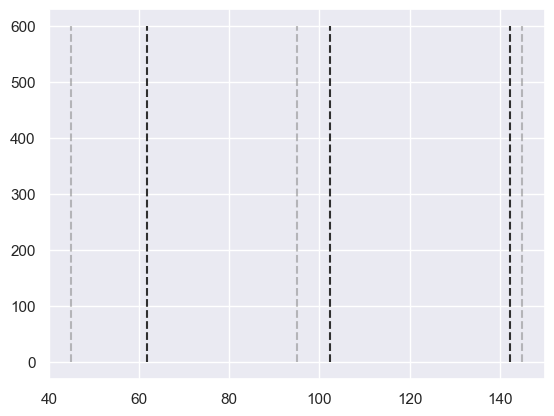

In [33]:
old = [45,95,145]
plt.vlines(candidate2,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)

# BO 4D

In [34]:
#bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)
bounds = torch.tensor([[avg_data['time'].min(),avg_data['temp'].min(),avg_data['sulf'].min() , avg_data['analyte'].min()], [avg_data['time'].max(), avg_data['temp'].max(), avg_data['sulf'].max() , avg_data['analyte'].max()]], dtype=dtype, device=device)
#[75.0, 100.0], [33.0, 100.0],[20.0,170.0],[30.0,600.0]
batch_size = 15 #train_size

# For EI 
best_f = torch.tensor(1 ,dtype=dtype) 
target_vector = torch.tensor([1],dtype=dtype) # target is 95% or highers

In [35]:
train_x = torch.tensor(x1, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y1, dtype=dtype)

## Create the surrogate model
gp_model = SingleTaskGP(train_x, train_y).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [36]:
acq_funcs = qExpectedImprovement(model=gp_model, best_f=best_f)

candidate1, _ = optimize_acqf(
    acq_function=acq_funcs,
    bounds=bounds,
    q=batch_size,
    num_restarts=15,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

candidate1

tensor([[ 97.7985,  93.1047,  78.1917,  66.2673],
        [341.1681, 116.9721,  98.6707,  94.0427],
        [559.3912, 136.0244,  81.8338,  36.4096],
        [268.5884,  70.2687,  95.7409,  92.1257],
        [186.3865, 125.1841,  78.1358,  43.3915],
        [574.7304,  84.1306,  96.1153,  62.4635],
        [268.3933, 142.3065,  84.8563,  75.7860],
        [550.9747,  50.0951,  78.0731,  70.0609],
        [231.7217, 111.5043,  81.2015,  41.4828],
        [260.2256,  70.6576,  94.0992,  63.0731],
        [324.7849, 123.1108,  91.6125,  95.5912],
        [545.2702, 100.1239,  86.0623,  59.3638],
        [270.4031, 142.8701,  75.3613,  91.9941],
        [198.9571, 123.2432,  97.3834,  74.4764],
        [540.2711,  53.6586,  76.1410,  48.9595]])

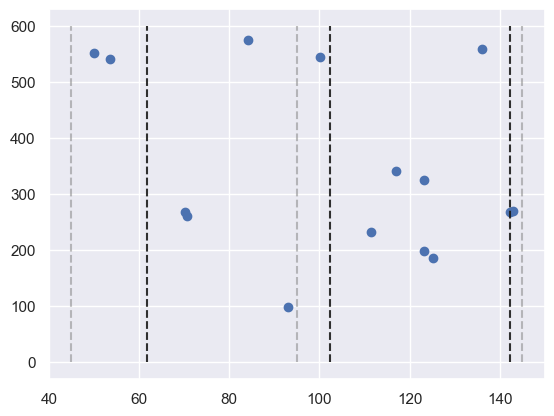

In [37]:
old = [45,95,145]
plt.vlines(candidate2,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)

plt.scatter(candidate1[:,1],candidate1[:,0])


# Projection ? (Cluster?)

In [38]:
temp4D = []

for i in range(candidate1.shape[0]):
    id = abs(candidate1[i,1]-candidate2).argmin()
    temp4D.append(candidate2[id])
temp4D =np.array(temp4D).T

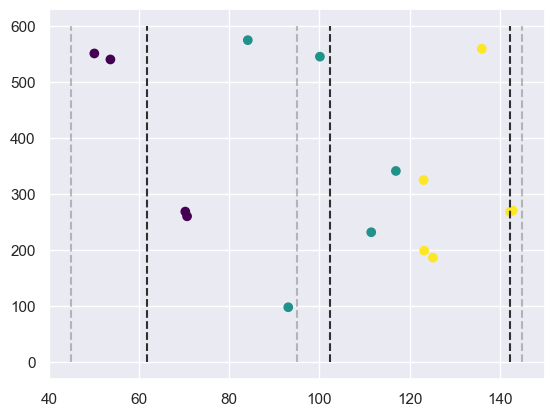

In [39]:
old = [45,95,145]
plt.vlines(candidate2,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(candidate1[:,1],candidate1[:,0],c=temp4D, cmap='viridis')

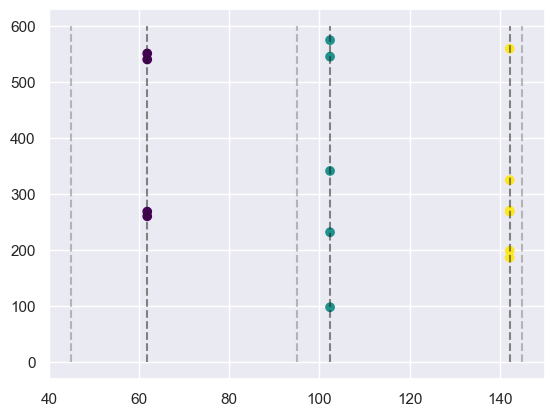

In [40]:
old = [45,95,145]
plt.vlines(candidate2,0,600, color = 'k',linestyle='dashed',alpha=0.5)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(temp4D,candidate1[:,0],c=temp4D, cmap='viridis')

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(dot_prd)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(candidate1[:,1].reshape(-1,1))
centroids = kmeans.cluster_centers_
centroids.round()

array([[ 61.],
       [130.],
       [ 97.]])